In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.text_classification.constants.misc import CHARCTERS
from torchlake.text_classification.models import CharCnn
from torchtext.vocab import build_vocab_from_iterator

# setting


In [2]:
data_path = Path("../../data/covid-tweet")
artifacts_path = Path("../../artifacts/charcnn")

In [3]:
batch_size = 128
context = NlpContext(max_seq_len=27*34+96)

# data

In [4]:
train_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_train.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [5]:
test_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_test.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [6]:
train_data['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [7]:
vocab = build_vocab_from_iterator(
    [*CHARCTERS],
    specials=context.special_tokens,
)

vocab.set_default_index(context.unk_idx)

In [8]:
train_data['OriginalTweet'] = train_data['OriginalTweet'].str.lower()
test_data['OriginalTweet'] = test_data['OriginalTweet'].str.lower()

In [9]:
label_encoder = LabelEncoder()
train_data['Sentiment'] = label_encoder.fit_transform(train_data['Sentiment'])

In [10]:
test_data['Sentiment'] = label_encoder.transform(test_data['Sentiment'])

In [11]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [12]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = [*text]
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [13]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [14]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 1014]) torch.Size([128])


# model


In [15]:
vocab_size = len(vocab)
label_size = train_data['Sentiment'].nunique()

In [16]:
device = torch.device(context.device)

In [17]:
model = CharCnn(vocab_size, label_size, context).to(device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
CharCnn                                  --
├─CharQuantization: 1-1                  --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       129,280
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       459,008
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
│    └─Conv1d: 2-7                       196,864
│    └─ReLU: 2-8                         --
│    └─Conv1d: 2-9                       196,864
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      196,864
│    └─ReLU: 2-12                        --
│    └─Conv1d: 2-13                      196,864
│    └─ReLU: 2-14                        --
│    └─MaxPool1d: 2-15                   --
├─Sequential: 1-3                        --
│    └─Linear: 2-16                      8,913,920
│    └─Dropout: 2-17              

# train


In [23]:
epoches = 30

In [24]:
trainer = ClassificationTrainer(epoches, device)

In [25]:
criterion = trainer.get_criterion(label_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [26]:
training_loss = trainer.run(train_iter, model, optimizer, criterion)

100%|██████████| 321/321 [00:16<00:00, 19.99it/s]


epoch 1 : 0.01202554803202364


100%|██████████| 321/321 [00:11<00:00, 26.84it/s]


epoch 2 : 0.011743338299897786


100%|██████████| 321/321 [00:11<00:00, 28.20it/s]


epoch 3 : 0.011554654821103606


100%|██████████| 321/321 [00:11<00:00, 27.20it/s]


epoch 4 : 0.011174995098205


100%|██████████| 321/321 [00:11<00:00, 27.50it/s]


epoch 5 : 0.010613136167559668


100%|██████████| 321/321 [00:12<00:00, 26.42it/s]


epoch 6 : 0.010170048598861583


100%|██████████| 321/321 [00:12<00:00, 26.39it/s]


epoch 7 : 0.009812039004006304


100%|██████████| 321/321 [00:10<00:00, 30.14it/s]


epoch 8 : 0.009339727655726245


100%|██████████| 321/321 [00:10<00:00, 30.01it/s]


epoch 9 : 0.008902562032178091


100%|██████████| 321/321 [00:10<00:00, 29.90it/s]


epoch 10 : 0.008371271728320378


100%|██████████| 321/321 [00:10<00:00, 30.39it/s]


epoch 11 : 0.007819295238494594


100%|██████████| 321/321 [00:10<00:00, 30.07it/s]


epoch 12 : 0.0072430854886654196


100%|██████████| 321/321 [00:10<00:00, 30.98it/s]


epoch 13 : 0.006487995081485432


100%|██████████| 321/321 [00:10<00:00, 31.01it/s]


epoch 14 : 0.005907872672891969


100%|██████████| 321/321 [00:10<00:00, 29.82it/s]


epoch 15 : 0.005172267224715088


100%|██████████| 321/321 [00:10<00:00, 31.47it/s]


epoch 16 : 0.004549198316822171


100%|██████████| 321/321 [00:10<00:00, 30.65it/s]


epoch 17 : 0.003888636659192519


100%|██████████| 321/321 [00:10<00:00, 29.65it/s]


epoch 18 : 0.0032640575736650845


100%|██████████| 321/321 [00:10<00:00, 29.75it/s]


epoch 19 : 0.0029160314565234327


100%|██████████| 321/321 [00:10<00:00, 29.33it/s]


epoch 20 : 0.0026129475117275184


100%|██████████| 321/321 [00:10<00:00, 29.63it/s]


epoch 21 : 0.002096448499474361


100%|██████████| 321/321 [00:10<00:00, 30.24it/s]


epoch 22 : 0.001818846703385151


100%|██████████| 321/321 [00:10<00:00, 29.99it/s]


epoch 23 : 0.0017310965064959456


100%|██████████| 321/321 [00:10<00:00, 30.67it/s]


epoch 24 : 0.001662666509196313


100%|██████████| 321/321 [00:10<00:00, 29.86it/s]


epoch 25 : 0.0014764652536700354


100%|██████████| 321/321 [00:10<00:00, 29.89it/s]


epoch 26 : 0.001235613150440876


100%|██████████| 321/321 [00:10<00:00, 30.05it/s]


epoch 27 : 0.0013958685209059282


100%|██████████| 321/321 [00:10<00:00, 29.71it/s]


epoch 28 : 0.0010490134832408639


100%|██████████| 321/321 [00:10<00:00, 30.52it/s]


epoch 29 : 0.0010220755649240241


100%|██████████| 321/321 [00:10<00:00, 30.86it/s]

epoch 30 : 0.0010863441347058955


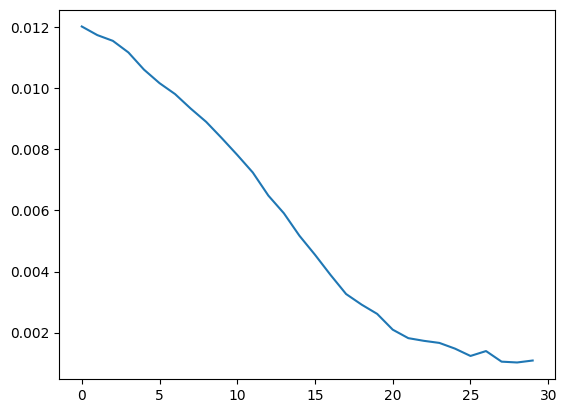

In [27]:
plt.plot(training_loss)

# inference


In [21]:
evaluator = ClassificationEvaluator(label_size, device)

In [29]:
train_confusion_matrix = evaluator.run(train_iter, model)

100%|██████████| 321/321 [00:10<00:00, 30.20it/s]

0.5935650887573964


In [22]:
test_confusion_matrix = evaluator.run(test_iter, model)

100%|██████████| 30/30 [00:01<00:00, 23.61it/s]

0.24232633279483037


In [23]:
per_class_accs = evaluator.get_per_class_accuracy(test_confusion_matrix)

evaluator.show_per_class_accuracy(label_encoder.classes_, per_class_accs.round(4))

Extremely Negative: 0.2479
Extremely Positive: 0.3
Negative  : 0.2083
Neutral   : 0.2542
Positive  : 0.2206


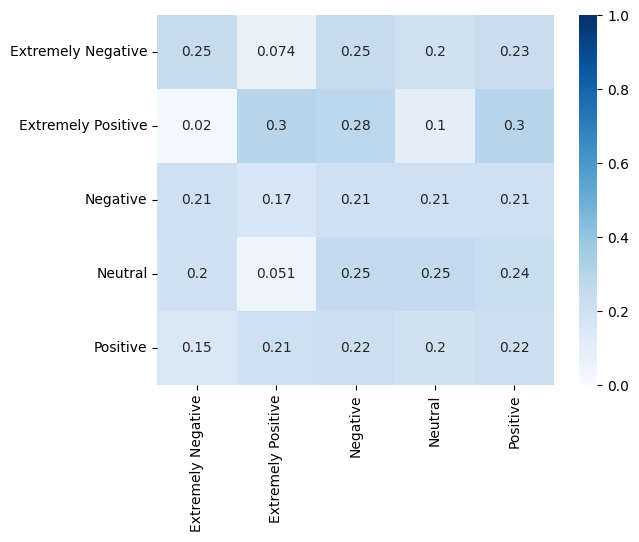

In [24]:
evaluator.plot_confusion_matrix(test_confusion_matrix, label_encoder.classes_, cmap='Blues')

In [19]:
model_path = artifacts_path.joinpath("charcnn.pth")

In [38]:
torch.save(model.state_dict(), model_path)

In [20]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>